In [1]:
#import libraries
import numpy as np
import pandas as pd
import networkx as nx
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

In [2]:
%matplotlib inline
import seaborn
plt.style.use('seaborn')#switch to seaborn style# TODO
seaborn.set_style(style='white')

In [3]:
tracks = pd.read_csv('data/tracks.csv', index_col=0, header=[0, 1]);
#load and normalize features
features= pd.read_csv('data/features.csv', index_col=0, header=[0, 1, 2])
dfmax=abs(features).max()
features=features.divide(dfmax)

genres=pd.read_csv('data/genres.csv', index_col=0, header=[0])


In [37]:
# Keep only the genre for each track
label=pd.DataFrame({('label','genre','main'): tracks['track']['genre_top'],
                    ('label','genre','sub'): tracks['track']['genres']})

# Keep on the tracks from small subset
label = label[tracks['set','subset'] == 'small']


# Keep only the genres we want
genre_list = ['Hip-Hop','Rock','Folk']#['Hip-Hop', 'Rock','Jazz','Classical','Pop','Electronic']
label = label[label['label']['genre']['main'].isin(genre_list)]

#add sub genres
genres_dict=genres['title'].to_dict()
genres_dict={str(key):genres_dict[key] for key in genres_dict}

label['label']['genre']['sub']=label['label']['genre']['sub'].str.replace('[^0-9| ]','').str.split(' ').apply(lambda x:'|'.join([genres_dict[k] for k in x ]))


# Merging
dataSet = features.merge(label, left_index=True, right_on='track_id')
#dataSet=dataSet.sort_values([('label', 'genre','main')])


In [38]:
print(sum(dataSet.label.genre.main=='Instrumental'))
label.label.genre.main.unique()

0


array(['Hip-Hop', 'Folk', 'Rock'], dtype=object)

In [39]:
#we calculate the distances of our dataset
distances = pdist(dataSet.drop(columns='label',level=0).values, metric='euclidean')

In [40]:
#We calculate the weights of our adjacency matrix
kernel_width = distances.mean()
weights = np.exp(-distances**2 / kernel_width**2)
adjacency_full = squareform(weights)

In [41]:
np.save("data/adjacency_HRJC.npy",adjacency_full)

In [42]:
adjacency_full=np.load("data/adjacency_HRJC.npy")

In [43]:
# plt.hist(weights)
# plt.title('Distribution of weights')
# plt.xlabel('Weights of links')
# plt.show()

In [44]:
#informatons over connectivity of main component 
adjacency=adjacency_full.copy() #we keep the original adjacency matrix
adjacency[adjacency < 0.65] = 0
graph=nx.from_numpy_matrix(adjacency)
print("#nodes= ",adjacency.shape[0])
print("#compo= ",nx.number_connected_components(graph))
list_comp=sorted(nx.connected_components(graph), key = len, reverse=True)
print("#nodes in giant component= ", len(list_comp[0]))
print("percentage of nodes in main component= ",len(list_comp[0])/adjacency.shape[0])

#nodes=  3000
#compo=  465
#nodes in giant component=  2512
percentage of nodes in main component=  0.8373333333333334


In [45]:
# list(nx.connected_component_subgraphs(graph))[0].node

In [46]:
#keep only the main component and corresponding label
conn_graph = list(nx.connected_component_subgraphs(graph))[0]
conn_label=label.iloc[list(list_comp[0])]

## Graph plot##

In [47]:
laplacian=nx.laplacian_matrix(conn_graph)

In [48]:
label=np.array(conn_label.label.genre.main)
label_num=label.copy()
label_num[label_num=='Hip-Hop']=-1
label_num[label_num=='Rock']=-0.3333
label_num[label_num=='Folk']=0.3333
label_num[label_num=='Pop']=1
label_num

array([-1, -1, 0.3333, ..., -1, 0.3333, -1], dtype=object)

In [49]:
e,eigenvectors = scipy.sparse.linalg.eigs(laplacian,k=6)

e=e.real
eigenvectors=eigenvectors.real

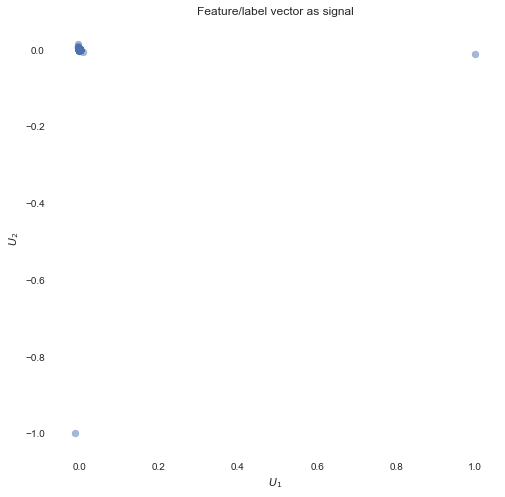

In [50]:
#using laplacian eigenmap
plt.figure(figsize=(8, 8))

plt.scatter(eigenvectors[:, 1], eigenvectors[:, 2], alpha=0.5, cmap='coolwarm')
plt.title('Feature/label vector as signal')
plt.xlabel('$U_1$')
plt.ylabel('$U_2$')
plt.show()

In [51]:
#using springlayout
coords = nx.spring_layout(conn_graph)  # Force-directed layout.

In [52]:
i=0
coords_x=[]
coords_y=[]
for i in (conn_graph.node):
    coords_x.append(coords[i][0])
    coords_y.append(coords[i][1]);   
    i+=1;
    

C:\Users\joachim\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


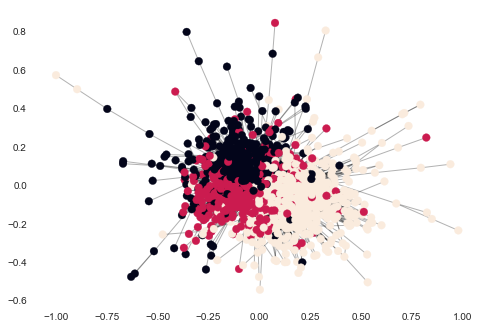

In [53]:
# np.save('data/coords_HRJC',coords)
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure(figsize=(20, 15))

# ax = fig.add_subplot(221, projection='3d')
# ax_c=ax.scatter(coords_x,coords_y, label_num, c=label_num,cmap="coolwarm")
# plt.colorbar(ax_c)
# fig.colorbar
# ax.set_title("Signal")

nx.draw_networkx_nodes(conn_graph, coords, node_size=60, node_color=label_num)
nx.draw_networkx_edges(conn_graph, coords, alpha=0.3)

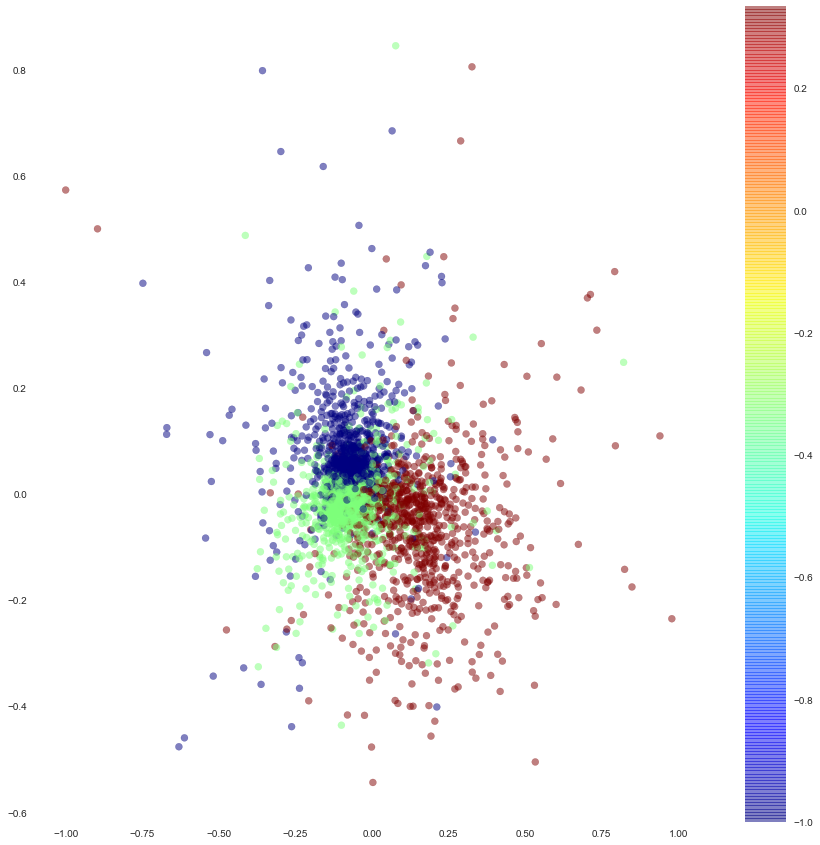

In [55]:
plt.figure(figsize=(15, 15))

plt.scatter(coords_x,coords_y,c=label_num , alpha=0.5, cmap='jet')

plt.colorbar()
plt.show()

In [ ]:
plt.figure(figsize=(15, 15))
nx.draw_networkx_nodes(conn_graph, coords,node_size=60, node_color=label_num)
nx.draw_networkx_edges(conn_graph, coords, alpha=0.3)
sm = plt.cm.ScalarMappable( norm=plt.Normalize(vmin=-1, vmax=1))
sm._A = []
plt.colorbar(sm)
plt.show()

In [ ]:
tmp_label=list(np.array(conn_label.label.genre.main))

i=0;
node_dict=dict()
for n in conn_graph.node:
    node_dict[n]=i
    i+=1;
conn_graph_rename=nx.relabel_nodes(conn_graph,node_dict)

label_dict={i : tmp_label[i] for i in range(len(conn_graph.node))}
    
nx.set_node_attributes(conn_graph_rename, values=label_dict, name="genre")

In [ ]:
# import random
# subnode=random.sample(list(conn_graph.node), 5000)
# sub_graph=conn_graph.subgraph(subnode)
nx.write_gexf(conn_graph_rename, "data/graph_small_HRFP.gexf")

In [ ]:
conn_graph_rename.node

# personal tests

In [ ]:
dataSet

In [ ]:
genre_top=genres[genres['parent']==0]
genre_top

In [ ]:
tracks_raw = pd.read_csv('../data/fma_metadata/raw_tracks.csv', index_col=0);
tracks_raw['track_url'][2]

In [ ]:
# find specific sample
samples=tracks[tracks['track']['genres']=='[15]']
samples_in_small=samples[samples['set']['subset'] == 'medium']
samples_in_small

In [ ]:
label['label']['genre']['main'].unique()